In [2]:
import os
import json
import cv2
import librosa
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from warnings import filterwarnings

filterwarnings(action='ignore')

In [1]:
!kaggle datasets download -d soumendraprasad/sound-of-114-species-of-birds-till-2022

Dataset URL: https://www.kaggle.com/datasets/soumendraprasad/sound-of-114-species-of-birds-till-2022
License(s): CC0-1.0
100% 2.05G/2.06G [00:29<00:00, 104MB/s]
100% 2.06G/2.06G [00:29<00:00, 75.1MB/s]


In [3]:
!unzip sound-of-114-species-of-birds-till-2022.zip

Archive:  sound-of-114-species-of-birds-till-2022.zip
  inflating: Birds Voice.csv         
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan10.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan11.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan12.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan13.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan14.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan15.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan16.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan17.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan18.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan19.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan2.mp3  
  inflating: Voice

In [4]:
def audio_to_tensors(audio_file):
    # Extract the Signal and Sample_Rate from Audio
    audio, sample_rate =librosa.load(audio_file)

    # Extract the MFCC Features and Aggrigate
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Convert into Tensors
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    return mfccs_tensors

In [5]:
# Extract the Features from Audio Files

# Audio Directory Path
directory = '/content/Voice of Birds/Voice of Birds'

extracted_features = []

# Count the total number of files
total_files = sum(len(files) for _, _, files in os.walk(directory))

# Initialize tqdm with the total number of files
with tqdm(total=total_files, desc='Processing files') as pbar:

  for target_class in os.listdir(directory):                               # List of All Target Folder Names in Directory

      target_class_path = os.path.join(directory, target_class)            # Make a Target Folder Path in Directory

      for audio_file in os.listdir(target_class_path):                     # List of All Audio Files in Target Folder

          audio_path = os.path.join(directory, target_class, audio_file)   # Make a Audio File Path from Target Folder in Directory

          features = audio_to_tensors(audio_path)                          # Extract the Features from the Audio File

          extracted_features.append([features, target_class])              # Append the Features and Target_Class in List

          pbar.update(1)                                                   # Update the progress bar for each file processed

# Creating DataFrame from Extracted Features with Class Labels
features_df = pd.DataFrame(extracted_features, columns=['features', 'class'])
# Encoding Class Labels using LabelEncoder

target_encoding = LabelEncoder().fit_transform(features_df['class'])
# Adding Encoded Class Labels Column to DataFrame

features_df['target'] = target_encoding.tolist()

# Creating a Dictionary based on Class and Target columns for Future Prediction

prediction_dict = features_df.set_index('target')['class'].to_dict()


Processing files: 100%|██████████| 2161/2161 [09:04<00:00,  3.97it/s]


In [6]:
# Save to JSON File

with open(file='/content/prediction.json', mode='w') as f:
    json.dump(prediction_dict, f)
# Converting Features into List
features = features_df['features'].tolist()
# Converting Targets into Lists
target = features_df['target'].tolist()

In [7]:
# Converting Features and Targets to TensorFlow Tensors

features_tensor = tf.convert_to_tensor(features)
target_tensor = tf.convert_to_tensor(target)

# Creating TensorFlow Dataset from Tensors

dataset = tf.data.Dataset.from_tensor_slices((features_tensor, target_tensor))

In [8]:
# Split the dataset into batches
batch_size = 32
dataset = dataset.batch(batch_size)

# Define a Function process to Split Dataset into Training(80%), Validation(10%) and Testing(10%) Sets

def train_validation_test_split(dataset, train_size=0.8, validation_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):

    dataset_batch_count = len(dataset)                                                  # Batch Images dataset Length is 68
    train_batch_count = int(dataset_batch_count * train_size)                           # int(68*0.8) ---> 54 Batches are Training
    validation_test_batch_count = int(dataset_batch_count * validation_size)            # int(68*0.1) ---> 6 Batches are validation & Remaining Testing

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)                             # Suffling the Dataset help to Model Understand the Data Well

    train_ds = dataset.take(train_batch_count)                                          # First 54 Batches are Training_Dataset
    validation_ds = dataset.skip(train_batch_count).take(validation_test_batch_count)   # Remaining 14 Batches ---> Next 6 Batch are Validation_Dataset
    test_ds = dataset.skip(train_batch_count).skip(validation_test_batch_count)         # Pending 8 Batches are Testing

    return train_ds, validation_ds, test_ds

train_ds, validation_ds, test_ds = train_validation_test_split(dataset)
len(train_ds), len(validation_ds), len(test_ds)

(54, 6, 8)

In [9]:
# Building an Optimized Data Pipeline for Enhanced Performance

# Training Dataset
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
validation_ds = validation_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Testing Dataset
test_ds = test_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

In [10]:
# Define the Parameters of Input_shape, Channel and Target

mfcc_features = 40    # Extracted features from Audio
channel = 1           # Mono Channel
target = 114          # Output Classes

input_shape = (mfcc_features, channel)
input_shape

(40, 1)

In [11]:
# Build a CNN Model Architecture

model = keras.Sequential([

            # Input Layer
            keras.layers.Input(shape=input_shape),

            # 1st Conv Layer
            keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # 2nd Conv Layer
            keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # 3rd Conv Layer
            keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # Flatten and Convert into 1-Dimentional Vector
            keras.layers.Flatten(),

            # 1st Fully Connected Dense Layer
            keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=1e-2)),
            keras.layers.Dropout(rate=0.3),

            # 2nd Fully Connected Dense Layer
            keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=1e-2)),
            keras.layers.Dropout(rate=0.3),

            # Output Layer
            keras.layers.Dense(units=target, activation='softmax')
        ])

model

<Sequential name=sequential, built=True>

In [13]:
# Display the Model Summary

# model.build(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 38, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 38, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 17, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 9, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 7, 256)              │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 114)                 │          58,482 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,144,434 (4.37 MB)

 Trainable params: 1,143,154 (4.36 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [14]:
# Compiling the Model with Optimizer, Loss, and Metrics

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Model Training with Training_Dataset and Evaluated with Validation_Dataset

history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=700,
                    verbose=1,
                    validation_data = validation_ds)
history

Epoch 1/700
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.0081 - loss: 17.4148 - val_accuracy: 0.0000e+00 - val_loss: 16.6813
Epoch 2/700
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.0129 - loss: 17.0341 - val_accuracy: 0.0104 - val_loss: 16.6146
Epoch 3/700
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.0135 - loss: 16.9276 - val_accuracy: 0.0156 - val_loss: 16.5707
Epoch 4/700
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0214 - loss: 16.7399 - val_accuracy: 0.0260 - val_loss: 16.5333
Epoch 5/700
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0336 - loss: 16.6248 - val_accuracy: 0.0052 - val_loss: 16.5052
Epoch 6/700
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.0477 - loss: 16.4084 - val_accuracy: 0.0052 - val_loss: 16.4502
Epoch 7/700
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.0353 - loss: 16.4394 - val_accuracy: 0.0156 - val_loss: 16.4039
Epoch 8/700
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0458 - loss: 16.3101

In [16]:
# Evaluating Model Performance on Test Dataset
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8257 - loss: 1.5902


[1.777477502822876, 0.796875]

In [17]:
# Accessing Training History Parameters
history.params

{'verbose': 1, 'epochs': 700, 'steps': 54}

In [18]:
# Accessing Keys of Training History
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [19]:
# Extracting Accuracy Metrics from Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting Loss Metrics from Training History
loss = history.history['loss']
val_loss = history.history['val_loss']

# Save the Model
model.save('/content/model.h5')

Text(0.5, 1.0, 'Training vs Validation Loss')

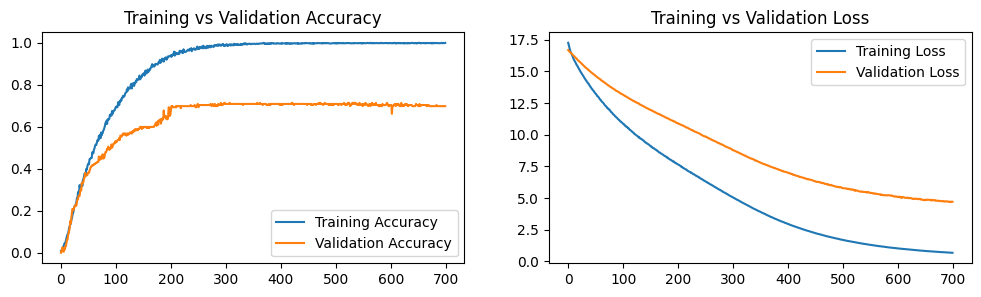

In [20]:
# Visualize the Acuuracy & Loss using Plots

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

In [21]:
def prediction(audio_file):

    # Load the Prediction JSON File to Predict Target_Label
    with open('/content/prediction.json', mode='r') as f:
        prediction_dict = json.load(f)

    # Extract the Audio_Signal and Sample_Rate from Input Audio
    audio, sample_rate =librosa.load(audio_file)

    # Extract the MFCC Features and Aggrigate
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Reshape MFCC features to match the expected input shape for Conv1D both batch & feature dimension
    mfccs_features = np.expand_dims(mfccs_features, axis=0)
    mfccs_features = np.expand_dims(mfccs_features, axis=2)

    # Convert into Tensors
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    # Load the Model and Prediction
    model = tf.keras.models.load_model('/content/model.h5')
    prediction = model.predict(mfccs_tensors)

    # Find the Maximum Probability Value
    target_label = np.argmax(prediction)

    # Find the Target_Label Name using Prediction_dict
    predicted_class = prediction_dict[str(target_label)]
    confidence = round(np.max(prediction)*100, 2)

    print(f'Predicted Class : {predicted_class}')
    print(f'Confidence : {confidence}%')

In [23]:
prediction('/content/Andean Guan15.mp3')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Predicted Class : Andean Guan_sound
Confidence : 62.08%


In [28]:
# Specify the folder path
folder_path = '/content/Voice of Birds/Voice of Birds/'

# Get a list of all subdirectories within the folder
subdirectories = [
    name.rstrip('_sound')  # Trim the trailing "_sound"
    for name in os.listdir(folder_path)
    if os.path.isdir(os.path.join(folder_path, name))
]

# Print the cleaned list of subdirectory names
print(subdirectories)

['Tataupa Tinam', 'Southern Brown Kiwi', 'Berlepschs Tinam', 'Rusty Tinam', 'Chilean Tinam', 'Philippine Megapode', 'Black-fronted Piping Gua', 'Quebracho Crested Tinam', 'White-browed Gua', 'Baudo Gua', 'Greater Rhea', 'Grey Tinam', 'Great Spotted Kiwi', 'Choco Tinam', 'White-winged Gua', 'Rusty-margined Gua', 'Malleefowl', 'New Guinea Scrubfowl', 'Lesser Rhea', 'Barred Tinam', 'Colombian Chachalaca', 'Chaco Chachalaca', 'Cauca Gua', 'Dwarf Tinam', 'Thicket Tinam', 'Melanesian Megapode', 'Brown Tinam', 'Darwins Nothura', 'Little Tinam', 'Brushland Tinam', 'Moluccan Megapode', 'Red-throated Piping Gua', 'Red-billed Brushturkey', 'Orange-footed Scrubfowl', 'Great Tinam', 'Elegant Crested Tinam', 'Little Chachalaca', 'Lesser Nothura', 'Grey-headed Chachalaca', 'Puna Tinam', 'Tawny-breasted Tinam', 'Nicobar Megapode', 'Black Tinam', 'Bearded Gua', 'Band-tailed Gua', 'White-bellied Nothura', 'Collared Brushturkey', 'Australian Brushturkey', 'White-bellied Chachalaca', 'Wattled Brushturkey'